## BMI 203 Final Project: Rap1 transcription factor analysis

This Jupyter notebook uses the neural network API developed for this assignment to classify Rap1 transcription factors.

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
from nn import nn, preprocess, io
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
# reloads the file constantly so you don't need to reset
%autoreload 2

#### Step 1: Load the genetic data

In [3]:
positives = io.read_text_file("data/rap1-lieb-positives.txt")
negatives = io.read_fasta_file("data/yeast-upstream-1k-negative.fa")

In [4]:
len(positives[3])

17

 The positive sequences are much shorter, and I will trim the negative sequences to match the length of the positive sequences.

In [5]:
trimmed_negatives = []
for negative in negatives:
    negative = negative[:17]
    trimmed_negatives.append(negative)

#### Step 2: Split data into training and testing
80% of the data will be used for training, while 20% will be used for testing.

**sample_seqs** from preprocess.py upsamples the lower class so that both classes have the same number of entries (average entries across the classes).

In [6]:
# concatenate the lists
seqs = list(positives) + list(trimmed_negatives)
# print one of the sequences (first one) to see that it looks ok
print("Sequence example:", seqs[400])

# make the labels, True for positive and False for negative to match seqs
labels = [True] * len(positives) + [False] * len(trimmed_negatives)

# upsample lower class and check lengths to make sure each seq has a label
sampled_seqs, sampled_labels = preprocess.sample_seqs(seqs, labels)
print("Number of sequences after sampling:", len(sampled_seqs), '\n', 'Number of labels after sampling:', len(sampled_labels))

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(sampled_seqs, sampled_labels, test_size = 0.2, random_state = 1)
print("Training examples:", len(X_train), '\n', "Testing examples:", len(X_test))

Sequence example: ATCACAGAACCCTTGAT
Number of sequences after sampling: 3300 
 Number of labels after sampling: 3300
Training examples: 2640 
 Testing examples: 660


In [7]:
# convert labels to arrays and make them 2D
y_test = np.array(y_test)
y_test = y_test.reshape(-1, 1)
y_train = np.array(y_train)
y_train = y_train.reshape(-1, 1)

In [8]:
# one hot encode sequences
X_train_encoded = preprocess.one_hot_encode_seqs(X_train)
X_test_encoded = preprocess.one_hot_encode_seqs(X_test)
print(X_train_encoded.shape) # should be the number of samples, 2640 and the number of nucleotides in each seq * 4 (68)
print(X_test_encoded.shape) # should be (660, 68)

(2640, 68)
(660, 68)


#### Step 2: Determine optimal parameters
An instance of my autoencoder was generated with BCE as the loss function since the output is  binary (positive or negative). Other parameters for use in my autoencoder were determined through a brief grid search with various learning rates, batch sizes, and epochs.

After grid search, the optimal parameters were determined to be a **learning rate of 0.01, batch size of 50, and 200 epochs** based on minimal loss values.

My neural network consists of 2 layers, which takes an input and encodes it into a lower-dimensional latent space to decode and reconstruct it. The autoencoder is 64x16x64.

In [9]:
arch = [{'input_dim': 68, 'output_dim': 16, 'activation': 'sigmoid'},
       {'input_dim': 16, 'output_dim': 68, 'activation': 'sigmoid'}]

In [10]:
# do a small grid search
# initialize parameters to test
lr_params = [0.01, 0.001]
batch_size_params = [50, 100]
epoch_params = [100, 200]
# initialize lists to store losses and the optimal parameters
losses = []
optimal_params = []

# do grid search
for lr in lr_params:
    for batch_size in batch_size_params:
        for epoch in epoch_params:
            test = nn.NeuralNetwork(arch, lr=lr, batch_size=batch_size, epochs=epoch, seed=42, loss_function = "bce")
            train_loss, test_loss = test.fit(X_train_encoded, y_train, X_test_encoded, y_test)
            losses.append(min((test_loss)))
            optimal_params.append([lr, batch_size, epoch])

In [11]:
#print the optimal parameters (learning rate, batch size, epochs)
optimal_params[losses.index(min(losses))]

[0.01, 50, 200]

#### Step 3: Train my neural network using optimal parameters

In [15]:
# initialize neural network architecture using the optimal parameters
arch = [{'input_dim': 68, 'output_dim': 16, 'activation': 'sigmoid'},
       {'input_dim': 16, 'output_dim': 68, 'activation': 'sigmoid'}]
# initialize autoencoder
network = nn.NeuralNetwork(arch, lr = 0.01, seed = 10, batch_size = 50, epochs = 200, loss_function = "mse")

In [17]:
# train autoencoder on the training data
train_loss, test_loss = network.fit(X_train_encoded, y_train, X_test_encoded, y_test)

#### Step 4: Plot losses per epoch

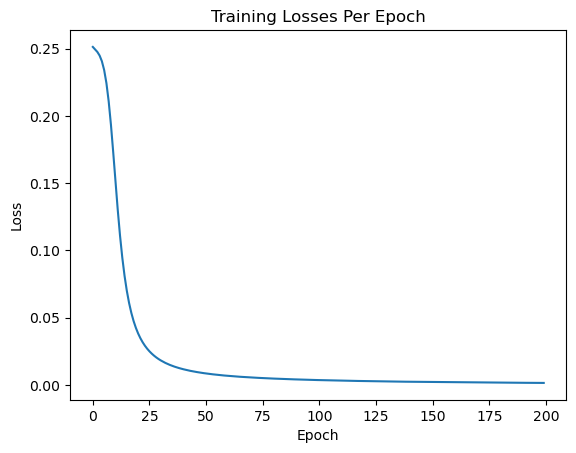

In [5]:
plt.figure()
plt.plot(train_loss)
plt.title("Training Losses Per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

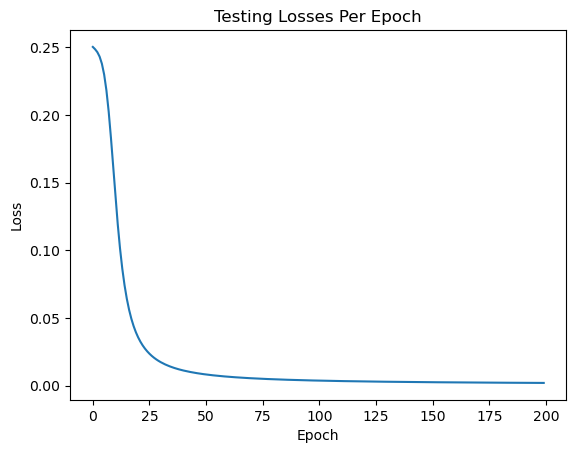

In [6]:
plt.figure()
plt.plot(test_loss)
plt.title("Testing Losses Per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Step 5: Quantify reconstruction error (accuracy)

In [28]:
# make predictions using test data
preds = network.predict(X_test_encoded)
preds

array([[0.9519363343879181, 0.9522302845391154, 0.9511496565993803, ...,
        0.9517278887934038, 0.9518765220182471, 0.9516533317934016],
       [0.9533720746027643, 0.9541725950972545, 0.9542422279610319, ...,
        0.9542465165359971, 0.9546242866571448, 0.9533136112253741],
       [0.022001852220698812, 0.02099188470955804, 0.021837393891756058,
        ..., 0.02090705991570671, 0.020766287588967335,
        0.020187352003864477],
       ...,
       [0.017998532668763344, 0.016285488411224826, 0.018311308554788554,
        ..., 0.016290744367813928, 0.016487270070410478,
        0.015510686502050976],
       [0.9636559161639671, 0.9632785831592301, 0.9633272581870421, ...,
        0.9638498221536743, 0.963641525340787, 0.9633572270596704],
       [0.9663511997531927, 0.9666838806458279, 0.9664567993186447, ...,
        0.966664703160093, 0.9669328351614966, 0.967034508293116]],
      dtype=object)

In [34]:
# Compute accuracy
preds = (preds >= 0.5) * 1
print("Final accuracy on testing set:", np.sum(preds == y_test) / len(y_test))

Final accuracy on testing set: 67.89696969696969
